# GCN

## Load the data

In [18]:
import os
from pathlib import Path
import pickle

PATH = Path.cwd().parents[2]

with open(os.path.join(PATH, "data/processed/graphs_labels/graphs_with_labels.pkl"), "rb") as f:
    graphs, labels = pickle.load(f)

### sample

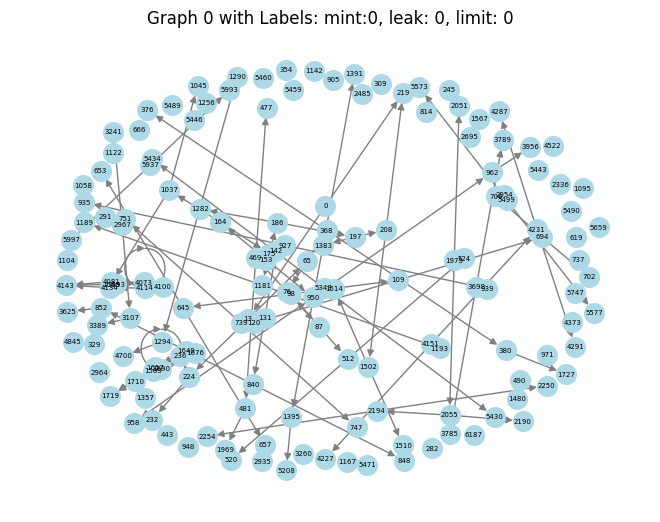

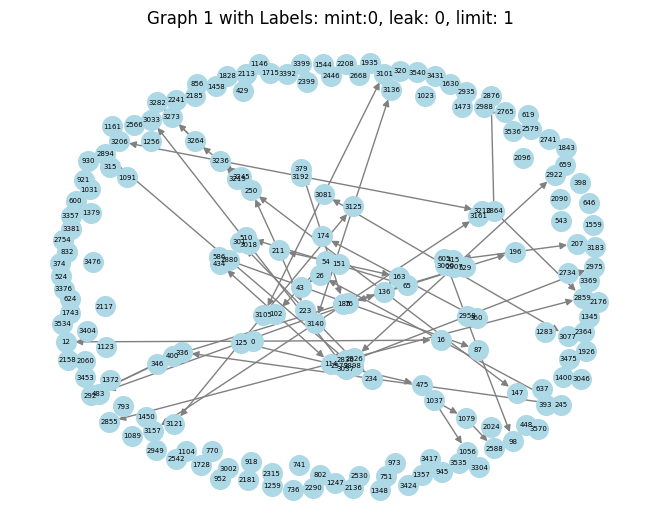

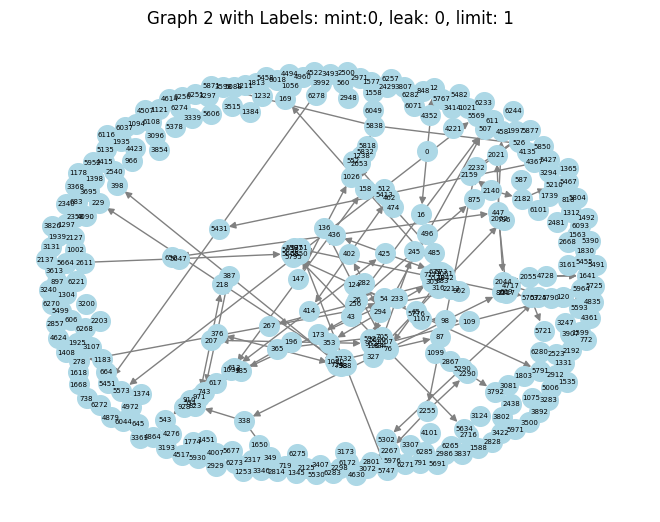

In [29]:
import networkx as nx
import matplotlib.pyplot as plt

for i, (graph, label) in enumerate(zip(graphs, labels)):
    nx.draw(graph, with_labels=True, node_color='lightblue', node_size=200, edge_color='gray', font_size=5)
    plt.title(f"Graph {i} with Labels: mint:{label['mint']}, leak: {label['mint']}, limit: {label['limit']}")
    plt.tight_layout()
    plt.show()
    if i == 2:
        break

## Install required packages.

In [41]:
!pip install -q torch

import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
print(torch.__version__)
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install git+https://github.com/pyg-team/pytorch_geometric.git


2.2.2
Looking in links: https://data.pyg.org/whl/torch-2.2.2.html
  Using cached torch_scatter-2.1.2.tar.gz (108 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [52 lines of output]
      Compiling without OpenMP...
      Compiling without OpenMP...
      Compiling without OpenMP...
      Compiling without OpenMP...
      running egg_info
      creating /private/var/folders/c8/rmlp9g456b5_c_vt71ncc0nm0000gn/T/pip-pip-egg-info-7_uwqmqv/torch_scatter.egg-info
      writing /private/var/folders/c8/rmlp9g456b5_c_vt71ncc0nm0000gn/T/pip-pip-egg-info-7_uwqmqv/torch_scatter.egg-info/PKG-INFO
      writing dependency_links to /private/var/folders/c8/rmlp9g456b5_c_vt71ncc0nm0000gn/T/pip-pip-egg-info-7_uwqmqv/torch_scatter.egg-info/dependency_links.txt
      writing requirements to /private/var/folders/c8/rmlp9g456b5_c_vt71ncc0nm0000gn/T/pip-pip-egg-info-7_uwqmqv/torch_scatter.egg-